In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
from ridgeplot import ridgeplot
import joypy
import seaborn as sns
from matplotlib import cm
import climpred
from xclim import sdba
from climpred.options import OPTIONS
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.lines import Line2D  # For custom legend entries
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.gridspec as gridspec
import hydroeval as he
import re

from function import preprocessUtils as putils
from function import masks
from function import verifications
from function import funs as f
from function import conf
from function import loadbias


warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

global dim_order, region_name, test_year, leads_
dim_order = conf.dim_order
region_name = 'CONUS'
test_year = 2019
leads_ = [6,13,20,27]

dir = '/glade/work/klesinger/FD_RZSM_deep_learning'
assert test_year == 2019, 'This is only the script for when the testing years are 2018-2019. Test year must = 2019.'
assert region_name == 'CONUS', 'This is only the script for CONUS, do not select any other region.'

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mask, mask_anom = masks.load_mask_vals(region_name)


In [ ]:
obs_source = 'GLEAM'

if obs_source == 'GLEAM':
    soil_dir = conf.gleam_data
elif obs_source == 'ERA5':
    soil_dir = conf.era_data

In [3]:
global custom_names
'''This is for the final plot for ACC and CRPS'''
custom_names = {
    'GEFSv12': 'NWP (2)', 'EMOS': 'DM-BC_EMOS (4)', 
    'DM-BC_DL': 'DM-BC-DL (2)', 'DL': 'DL (16)',
    'DL-DM': 'DL-DM (20)', 'ML_NWP_OBS': 'ML_NWP_OBS (2)',
    'ECMWF':'NWP (2)', 'NWP_BC': 'NWP-BC (2)',
}

        
def return_name(name):
    if 'XGBOOST' in name:
        name_out = 'ML_NWP_OBS'
    else:
        name_out = name
    custom_names = {name: name_out}

    return(custom_names)

In [4]:
'''Testing and validation dates only for the year 2019'''

test_start = '2018-01-01'
test_end = '2019-12-31'
val_start = '2016-01-01'
val_end = '2017-12-31'
train_start  = '2000-01-01'


'''Test subsets of obs, ecmwf raw, gefsv12 raw '''
global obs_anomaly_SubX_format, baseline_gefs, baseline_ecmwf, var_OUT, template_testing_only
obs_anomaly_SubX_format, baseline_gefs, baseline_ecmwf, var_OUT, template_testing_only = verifications.open_obs_and_baseline_files_multiple_leads(region_name, leads_, test_start, test_end, mask_anom, soil_dir)

#Open the gleam percentile/anom files
init_dates,dt_dates,only_testing_dates = dataLoad.return_init_and_testing_dates(region_name,test_start,test_end)

obs_anom_percentile = xr.open_mfdataset(f'{soil_dir}/{region_name}/RZSM_anom_and_percentile_reformat/*').sel(S=slice(test_start,test_end))
obs_anom_percentile['S'] = only_testing_dates
obs_anom_percentile

''' Load EMOS results (only for CONUS). We have not completed EMOS on any other region except CONUS'''
if region_name == 'CONUS':
    emos_template = xr.open_dataset(f'Data/EMOS/{region_name}/EMOS_11_test_predictions_12_weeks_before.nc')
    emos_template = emos_template.rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'})
    emos_testing = emos_template.sel(S=slice(test_start,test_end))

test_dates_subx = only_testing_dates

Loading soil data all the baseline files for observations, GEFSv12, and ECMWF for region CONUS
Loading GLEAM observations
Loading GEFS data
Loading ECMWF data


In [5]:
# # Experiment info for plotting
# black = ['EX0','EX13'] # bias-correction
# red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] # obs.-driven
# blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
#        'EX18','EX19','EX20','EX21','EX27','EX28'] # hybrid

global obs_original,obs_raw
obs_original = xr.open_dataset(f'{soil_dir}/{region_name}/RZSM_anomaly.nc').rename({'SMsurf':'RZSM'}).drop('season').load()
obs_raw = xr.open_dataset(f'{soil_dir}/{region_name}/RZSM_weighted_mean_0_100cm.nc4').rename({'SMsurf':'RZSM'}).load()

init_dates = putils.get_init_date_list(f'{conf.gefsv12_data}/{region_name}/soilw_bgrnd')
dt_dates = [pd.to_datetime(i) for i in init_dates]

#Load previously created data (percentiles of the anomaly)
# global emcwf_perc, gefs_perc
# ecmwf_perc = verifications.load_ECMWF_percentile_anomaly(region_name).sel(S=slice(test_start,test_end)).load()
# gefs_perc = verifications.load_GEFSv12_percentile_anomaly(region_name).sel(S=slice(test_start,test_end)).load()

# Lineplot ACC and CRPS all experiments

In [6]:

def add_lineplot_to_dataframe(df,fcst_vals,name_of_fcst, metric,week, mean_or_median):
    # df = pd.DataFrame()
    def return_color(name_of_fcst):
        black = ['EX0','EX13'] # bias-corrected DL
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] #Observation driven
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28','EX29'] #Hybrid

        black2 = ['DM-BC_DL']
        red2 = ['DL']
        blue2 = ['DL-DM']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'NWP_BC'

        yellow = 'EMOS'

        if (name_of_fcst in black) or (name_of_fcst in black2):
            color = 'black'
        elif (name_of_fcst in red) or (name_of_fcst in red2):
            color = 'red'
        elif (name_of_fcst in blue) or (name_of_fcst in blue2):
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
        return(color)

    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            if mean_or_median == 'mean':
                try:
                    data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
                except KeyError:
                    data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
            if mean_or_median == 'median':
                try:
                    data = fcst_vals.sel(lead=lead).median()[putils.xarray_varname(fcst_vals)].values
                except KeyError:
                    data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        if mean_or_median == 'mean':
            data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])

    return(df)


'''Only the single value for all the experiments'''

def add_lineplot_to_dataframe_average(df,fcst_vals,name_of_fcst, metric,week, mean_or_median):
    # df = pd.DataFrame()

    def return_color(name_of_fcst):
        black = ['DM-BC_DL']
        red = ['DL']
        blue = ['DL-DM']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'XGBOOST'

        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
            
        return(color)

    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            if mean_or_median == 'mean':
                data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
            elif mean_or_median == 'median':
                data = fcst_vals.sel(lead=lead).median()[putils.xarray_varname(fcst_vals)].values
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        if mean_or_median == 'mean':
            data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
            
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    
    return(df)

def add_lineplot_to_dataframe_average_by_week(df,fcst_vals,name_of_fcst, metric,week, mean_or_median, lead, idLead):
    # df = pd.DataFrame()

    def return_color(name_of_fcst):
        black = ['DM-BC_DL']
        red = ['DL']
        blue = ['DL-DM']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'XGBOOST'

        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
            
        return(color)

    if week==10:
        if mean_or_median == 'mean':
            data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.sel(lead=lead).median()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[idLead+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        if mean_or_median == 'mean':
            data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
            
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    
    return(df)

In [7]:
def common_UNET_experiments(correct_experiments):
    only_RZSM = [j for j in correct_experiments if 'RZSM' in j] 
    only_ensemble= [j for j in only_RZSM if 'final' not in j]
    only_ensemble = [j for j in only_ensemble if 'Residual' not in j]
    only_2019 = [j for j in only_ensemble if '2012' not in j]
    only_2019 = [j for j in only_ensemble if 'ERA5' not in j]
    return(only_2019)

def common_UNET_no_regular_experiments(correct_experiments):
    only_RZSM = [j for j in correct_experiments if 'RZSM' in j] 
    only_ensemble= [j for j in only_RZSM if 'final' not in j]
    only_ensemble = [j for j in only_ensemble if 'Residual' not in j]
    only_ensemble = [j for j in only_ensemble if 'regular' not in j]
    only_2019 = [j for j in only_ensemble if '2012' not in j]
    return(only_2019)

In [8]:
# def return_EMOS_average(region_name,test_start,test_end,obs_original,df_acc, df_crps,ecmwf_acc):
#     print('Adding EMOS results')
#     '''This is for adding all 4 EMOS experiments, but for some ready it is breaking right now and I'm not sure why (it kills the kernel)'''
#     emos_files_full = sorted(glob(f'Data/EMOS/{region_name}/EMOS_11*test_predictions*.nc'))
    
#     # Loop through all the EMOS file experiments
#     e_acc, e_crps = ecmwf_acc.copy(deep=True), ecmwf_acc.copy(deep=True)

#     e_acc[putils.xarray_varname(e_acc)][:,:,:],  e_crps[putils.xarray_varname(e_crps)][:,:,:] = 0, 0

#     # Loop through all the EMOS file experiments
#     for idx,file in enumerate(emos_files_full):
#         with xr.open_dataset(file) as emos_:
#             # break
#             emos_ = xr.open_dataset(file).rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'}).sel(S=slice(test_start,test_end))
#             #First get the ACC values of GEFS and ECMWF relative to observations
#             emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
#             add_  = (e_acc[putils.xarray_varname(e_acc)].values + emos_acc[putils.xarray_varname(emos_acc)].sel(lead=[6,13,20,27]).values)
#             e_acc[putils.xarray_varname(e_acc)][:,:,:] = add_
    
#             emos_crps = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
#             emos_crps = emos_crps.mean(dim='init')
#             add_  = (e_crps[putils.xarray_varname(e_crps)].values + emos_crps[putils.xarray_varname(emos_crps)].sel(lead=[6,13,20,27]).values)
#             e_crps[putils.xarray_varname(e_crps)][:,:,:] = add_

#     #Divide
#     e_acc = e_acc /len(emos_files_full)
#     e_crps = e_crps /len(emos_files_full)
#     #RE ADD MASK
#     mm = ~np.isnan(emos_.isel(M=0,S=0).sel(L=[6,13,20,27]))[putils.xarray_varname(emos_)].values
#     e_acc = xr.where(mm==True,e_acc,np.nan)
#     e_crps = xr.where(mm==True,e_crps,np.nan)
    
#     df_acc = add_lineplot_to_dataframe(df_acc,e_acc,'EMOS', 'ACC',10,'mean')
#     df_crps = add_lineplot_to_dataframe(df_crps,e_crps,'EMOS', 'CRPSS',10,'median')
#     return df_acc, df_crps

In [9]:
# def return_EMOS_average_by_season(region_name,test_start,test_end,obs_original,df_acc, df_crps,template):
#     print('Adding EMOS results')
#     '''This is for adding all 4 EMOS experiments, but for some ready it is breaking right now and I'm not sure why (it kills the kernel)'''
#     emos_files_full = sorted(glob(f'Data/EMOS/{region_name}/EMOS_11*test_predictions*.nc'))
        
#     seasons = {
#         "DJF": [12, 1, 2],  # Winter
#         "MAM": [3, 4, 5],   # Spring
#         "JJA": [6, 7, 8],   # Summer
#         "SON": [9, 10, 11]  # Fall
#     }

#     # Initialize dictionaries to store seasonal results
#     seasonal_acc = {season: template.copy(deep=True) for season in seasons}
#     seasonal_crps = {season: template.copy(deep=True) for season in seasons}
    
#     # Set initial values to zero
#     for season in seasons:
#         seasonal_acc[season][putils.xarray_varname(template)][:, :, :] = 0
#         seasonal_crps[season][putils.xarray_varname(template)][:, :, :] = 0

#      # Loop through all the EMOS experiments
#     for idx, file in enumerate(emos_files_full):
#         with xr.open_dataset(file) as emos_:
#             emos_ = xr.open_dataset(file).rename({'idate': 'S', 'model': 'M', 'vdate': 'L', 'latitude': 'Y', 'longitude': 'X'}).sel(S=slice(test_start, test_end))
#             emos_.close()
#             # Assign season to each data point based on the month
#             emos_['month'] = emos_['S'].dt.month
    
#             for season, months in seasons.items():
#                 # Select seasonal data
#                 seasonal_emos = emos_.where(emos_['month'].isin(months), drop=True)
#                 seasonal_obs = obs_original
    
#                 # Compute ACC
#                 emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(seasonal_emos), verifications.rename_obs_for_climpred(seasonal_obs))
#                 add_acc = seasonal_acc[season][putils.xarray_varname(seasonal_acc[season])].values + emos_acc[putils.xarray_varname(emos_acc)].sel(lead=[6, 13, 20, 27]).values
#                 seasonal_acc[season][putils.xarray_varname(seasonal_acc[season])][:, :, :] = add_acc
    
#                 # Compute CRPS
#                 emos_crps = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(seasonal_emos), verifications.rename_obs_for_climpred(seasonal_obs))
#                 emos_crps = emos_crps.mean(dim='init')
#                 add_crps = seasonal_crps[season][putils.xarray_varname(seasonal_crps[season])].values + emos_crps[putils.xarray_varname(emos_crps)].sel(lead=[6, 13, 20, 27]).values
#                 seasonal_crps[season][putils.xarray_varname(seasonal_crps[season])][:, :, :] = add_crps



#     #Divide
#     e_acc = e_acc /len(emos_files_full)
#     e_crps = e_crps /len(emos_files_full)
#     #RE ADD MASK
#     mm = ~np.isnan(emos_.isel(M=0,S=0).sel(L=[6,13,20,27]))[putils.xarray_varname(emos_)].values
#     e_acc = xr.where(mm==True,e_acc,np.nan)
#     e_crps = xr.where(mm==True,e_crps,np.nan)
    
#     df_acc = add_lineplot_to_dataframe(df_acc,e_acc,'EMOS', 'ACC',10,'mean')
#     df_crps = add_lineplot_to_dataframe(df_crps,e_crps,'EMOS', 'CRPSS',10,'median')
#     return df_acc, df_crps

In [10]:


def filter_files_by_ex(file_list, color_list, week_):
    filtered_files = []
    
    for file in file_list:
        match = re.search(rf'Wk{week_}_testing_EX(\d+)_RZSM', file)
        if match:
            ex_value = f"EX{match.group(1)}"
            if ex_value in color_list:
                filtered_files.append(file)
    
    return filtered_files

def return_file_list_by_category(region_name, week_):
    black = ['EX0','EX13']
    red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
    blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
           'EX18','EX19','EX20','EX21','EX27','EX28','EX29']
    
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data
    #First find the correct experiments
    bias_correction_black = filter_files_by_ex(unet_files, black, week_)
    hybrid_blue = filter_files_by_ex(unet_files, blue, week_)
    obs_red = filter_files_by_ex(unet_files, red, week_)
    return bias_correction_black, hybrid_blue, obs_red


def create_empty_array(ecmwf_acc, day_num):
    u_acc = ecmwf_acc.sel(lead=day_num).copy(deep=True)
    u_crps = ecmwf_acc.sel(lead=day_num).copy(deep=True)
    u_acc[putils.xarray_varname(u_acc)][:,:] = 0
    u_crps[putils.xarray_varname(u_crps)][:,:] = 0
    return u_acc, u_crps

In [11]:
def calculate_ACC_raw_forecast_all_seasons(obs_original, gefs, ecmwf):

    df_acc_full = pd.DataFrame()
    df_crps_full = pd.DataFrame()
    
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    gefs_crps = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_crps = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    diff_nwp = (gefs_acc + ecmwf_acc)/2
    df_acc_full = add_lineplot_to_dataframe(df_acc_full,diff_nwp,'GEFSv12', 'ACC',10, 'mean') #Just keep the name the same for later

    diff_nwp = (gefs_crps + ecmwf_crps)/2
    df_crps_full = add_lineplot_to_dataframe(df_crps_full,diff_nwp,'GEFSv12', 'CRPSS',10, 'median') #Just keep the name the same for later
    return df_acc_full, df_crps_full

In [12]:


def calculate_ACC_raw_forecast_split_seasons(obs_original, gefs, ecmwf):
    df_acc_djf = pd.DataFrame()
    df_acc_mam = pd.DataFrame()
    df_acc_jja = pd.DataFrame()
    df_acc_son = pd.DataFrame()
    
    df_crps_djf = pd.DataFrame()
    df_crps_mam = pd.DataFrame()
    df_crps_jja = pd.DataFrame()
    df_crps_son = pd.DataFrame()

    seasons = {
        "DJF": [12, 1, 2],  # Winter
        "MAM": [3, 4, 5],   # Spring
        "JJA": [6, 7, 8],   # Summer
        "SON": [9, 10, 11]  # Fall
    }

    for season, months in seasons.items():
        # break
        # Filter datasets for the current season
        obs_season = obs_original
        gefs_season = gefs.sel(S=gefs['S'].dt.month.isin(months))
        ecmwf_season = ecmwf.sel(S=ecmwf['S'].dt.month.isin(months))

        # Compute ACC and CRPSS for the season
        gefs_acc = verifications.create_climpred_ACC(
            verifications.rename_subx_for_climpred(gefs_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )
        ecmwf_acc = verifications.create_climpred_ACC(
            verifications.rename_subx_for_climpred(ecmwf_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )

        gefs_crps = verifications.create_climpred_CRPSS(
            verifications.rename_subx_for_climpred(gefs_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )
        ecmwf_crps = verifications.create_climpred_CRPSS(
            verifications.rename_subx_for_climpred(ecmwf_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )

        # Compute the mean ACC and CRPSS for GEFS and ECMWF
        diff_nwp_acc = (gefs_acc + ecmwf_acc) / 2
        diff_nwp_crps = (gefs_crps + ecmwf_crps) / 2

        if season == 'DJF':
            # Store results in DataFrame
            df_acc_djf = add_lineplot_to_dataframe(df_acc_djf, diff_nwp_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_crps_djf = add_lineplot_to_dataframe(df_crps_djf, diff_nwp_crps, 'GEFSv12', f'CRPSS', 10, 'median')
        elif season == 'MAM':
            df_acc_mam = add_lineplot_to_dataframe(df_acc_mam, diff_nwp_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_crps_mam = add_lineplot_to_dataframe(df_crps_mam, diff_nwp_crps, 'GEFSv12', f'CRPSS', 10, 'median')
        elif season == 'JJA':            
            df_acc_jja = add_lineplot_to_dataframe(df_acc_jja, diff_nwp_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_crps_jja = add_lineplot_to_dataframe(df_crps_jja, diff_nwp_crps, 'GEFSv12', f'CRPSS', 10, 'median')
        elif season == 'SON':
            df_acc_son = add_lineplot_to_dataframe(df_acc_son, diff_nwp_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_crps_son = add_lineplot_to_dataframe(df_crps_son, diff_nwp_crps, 'GEFSv12', f'CRPSS', 10, 'median')
               
    return df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son


In [13]:
def return_EMOS_combined(region_name, test_start, test_end, obs_original, df_acc_full, df_crps_full, template, df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son, df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son,leads):
    print('Adding EMOS results (all seasons and seasonal)')

    emos_files_full = sorted(glob(f'Data/EMOS/{region_name}/EMOS_11*test_predictions*.nc'))

    # Define seasons
    seasons = {
        "DJF": [12, 1, 2],  # Winter
        "MAM": [3, 4, 5],   # Spring
        "JJA": [6, 7, 8],   # Summer
        "SON": [9, 10, 11]  # Fall
    }

    # Initialize all-season results
    e_acc, e_crps = template.copy(deep=True), template.copy(deep=True)
    e_acc[putils.xarray_varname(e_acc)][:, :, :] = 0
    e_crps[putils.xarray_varname(e_crps)][:, :, :] = 0

    # Initialize dictionaries to store seasonal results
    seasonal_acc = {season: e_acc.copy(deep=True) for season in seasons}
    seasonal_crps = {season: e_crps.copy(deep=True) for season in seasons}

    # Set initial values to zero for each season
    for season in seasons:
        seasonal_acc[season][putils.xarray_varname(e_acc)][:, :, :] = 0
        seasonal_crps[season][putils.xarray_varname(e_crps)][:, :, :] = 0

    # Loop through all the EMOS experiments
    for idx, file in enumerate(emos_files_full):
        # break
        with xr.open_dataset(file) as emos_:
            emos_ = emos_.rename({'idate': 'S', 'model': 'M', 'vdate': 'L', 'latitude': 'Y', 'longitude': 'X'}).sel(S=slice(test_start, test_end))
        
            # Compute ACC for all seasons
            emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
            e_acc[putils.xarray_varname(e_acc)][:, :, :] += emos_acc[putils.xarray_varname(emos_acc)].sel(lead=leads).values

            # Compute CRPS for all seasons
            emos_crps = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
            emos_crps = emos_crps.mean(dim='init')
            e_crps[putils.xarray_varname(e_crps)][:, :, :] += emos_crps[putils.xarray_varname(emos_crps)].sel(lead=leads).values

            # Assign season to each data point based on the month
            emos_['month'] = emos_['S'].dt.month

            for season, months in seasons.items():
                # Select seasonal data
                seasonal_emos = emos_.where(emos_['month'].isin(months), drop=True)
                seasonal_obs = obs_original

                # Compute ACC for season
                emos_acc_season = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(seasonal_emos), verifications.rename_obs_for_climpred(seasonal_obs))
                seasonal_acc[season][putils.xarray_varname(seasonal_acc[season])][:, :, :] += emos_acc_season[putils.xarray_varname(emos_acc_season)].sel(lead=[6, 13, 20, 27]).values

                # Compute CRPS for season
                emos_crps_season = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(seasonal_emos), verifications.rename_obs_for_climpred(seasonal_obs))
                emos_crps_season = emos_crps_season.mean(dim='init')
                seasonal_crps[season][putils.xarray_varname(seasonal_crps[season])][:, :, :] += emos_crps_season[putils.xarray_varname(emos_crps_season)].sel(lead=[6, 13, 20, 27]).values

    # Normalize and apply mask for all-season results
    e_acc /= len(emos_files_full)
    e_crps /= len(emos_files_full)
    
    mm = ~np.isnan(emos_.isel(M=0, S=0).sel(L=leads))[putils.xarray_varname(emos_)].values
    e_acc = xr.where(mm, e_acc, np.nan)
    e_crps = xr.where(mm, e_crps, np.nan)

    # Add all-season results to DataFrame
    df_acc_full = add_lineplot_to_dataframe(df_acc_full, e_acc, 'EMOS', 'ACC', 10, 'mean')
    df_crps_full = add_lineplot_to_dataframe(df_crps_full, e_crps, 'EMOS', 'CRPSS', 10, 'median')

    # Normalize and apply mask for seasonal results
    for season in seasons:
        # break
        seasonal_acc[season] /= len(emos_files_full)
        seasonal_crps[season] /= len(emos_files_full)
        
        seasonal_acc[season] = xr.where(mm, seasonal_acc[season], np.nan)
        seasonal_crps[season] = xr.where(mm, seasonal_crps[season], np.nan)
        
        # Add seasonal results to DataFrame
        #winter
        if season == 'DJF':
            df_acc_djf = add_lineplot_to_dataframe(df_acc_djf, seasonal_acc[season], f'EMOS', 'ACC', 10, 'mean')
            df_crps_djf = add_lineplot_to_dataframe(df_crps_djf, seasonal_crps[season], f'EMOS', 'CRPSS', 10, 'median')
        elif season == "MAM":
            df_acc_mam = add_lineplot_to_dataframe(df_acc_mam, seasonal_acc[season], f'EMOS', 'ACC', 10, 'mean')
            df_crps_mam = add_lineplot_to_dataframe(df_crps_mam, seasonal_crps[season], f'EMOS', 'CRPSS', 10, 'median')
        elif season == "JJA":
            df_acc_jja = add_lineplot_to_dataframe(df_acc_jja, seasonal_acc[season], f'EMOS', 'ACC', 10, 'mean')
            df_crps_jja = add_lineplot_to_dataframe(df_crps_jja, seasonal_crps[season], f'EMOS', 'CRPSS', 10, 'median')
        elif season == "SON":
            df_acc_son = add_lineplot_to_dataframe(df_acc_son, seasonal_acc[season], f'EMOS', 'ACC', 10, 'mean')
            df_crps_son = add_lineplot_to_dataframe(df_crps_son, seasonal_crps[season], f'EMOS', 'CRPSS', 10, 'median')

    return df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son


In [14]:
def return_UNET_combined(region_name, test_start, test_end, obs_original, df_acc_full, df_crps_full, template, df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son, df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son,leads):
    
    # Define seasons
    seasons = {
        "DJF": [12, 1, 2],  # Winter
        "MAM": [3, 4, 5],   # Spring
        "JJA": [6, 7, 8],   # Summer
        "SON": [9, 10, 11]  # Fall
    }
    
    # Initialize all-season results
    e_acc, e_crps = template.copy(deep=True), template.copy(deep=True)
    e_acc[putils.xarray_varname(e_acc)][:, :, :] = 0
    e_crps[putils.xarray_varname(e_crps)][:, :, :] = 0
    
    # Initialize dictionaries to store seasonal results
    seasonal_acc = {season: e_acc.copy(deep=True) for season in seasons}
    seasonal_crps = {season: e_crps.copy(deep=True) for season in seasons}
    
    # Set initial values to zero for each season
    for season in seasons:
        seasonal_acc[season][putils.xarray_varname(e_acc)][:, :, :] = 0
        seasonal_crps[season][putils.xarray_varname(e_crps)][:, :, :] = 0
    
    
    obs_forecast_boolean = np.isnan(obs)
    
    #Add to a new gefs template for masking
    obs_forecast_boolean2 = gefs.copy(deep=True)
    obs_forecast_boolean2.RZSM[:,:,:,:,:] = obs_forecast_boolean['var']
    
    for idLead, week_ in enumerate([1, 2, 3, 4]):
        # break
        
        bias_correction_black, hybrid_blue, obs_red = return_file_list_by_category(region_name, week_)
        day_num = (week_ * 7) - 1  # Lead time in days
    
        for model, name in zip([bias_correction_black, hybrid_blue, obs_red], ['DM-BC_DL', 'DL-DM', 'DL']):
            # break
            print(f'Processing {name} for WEEK {week_}.')
            u_acc, u_crps = e_acc.copy(deep=True).sel(lead=day_num), e_crps.copy(deep=True).sel(lead=day_num)
    
            for i in model:
                new_source = 'ECMWF' if 'ECMWF' in i else 'GEFSv12'
                test_name = i.split('testing_')[-1].split('.npy')[0]
                
                # Load forecast file
                forecast = verifications.load_UNET_files(
                    gefs=gefs, file=i, region_name=region_name, day_num=day_num, 
                    new_source=new_source, test_year=test_year
                )
                
                # Apply land mask
                forecast = forecast.where(obs_forecast_boolean2 == 0, np.nan)
                
                # Compute ACC and CRPS
                unet_acc = verifications.create_climpred_ACC(
                    verifications.rename_subx_for_climpred(forecast), 
                    verifications.rename_obs_for_climpred(obs_original)
                ).sel(lead=day_num)
    
                unet_crps = verifications.create_climpred_CRPSS(
                    verifications.rename_subx_for_climpred(forecast), 
                    verifications.rename_obs_for_climpred(obs_original)
                ).sel(lead=day_num).mean(dim='init')
    
                # Accumulate values
                u_acc[putils.xarray_varname(u_acc)] += unet_acc[putils.xarray_varname(unet_acc)]
                u_crps[putils.xarray_varname(u_crps)] += unet_crps[putils.xarray_varname(unet_crps)]
    
            # Average over model members
            u_acc /= len(model)
            u_crps /= len(model)
    
            # Reapply mask
            mask = ~np.isnan(template[putils.xarray_varname(template)].sel(lead=day_num))
            u_acc = xr.where(mask, u_acc, np.nan)
            u_crps = xr.where(mask, u_crps, np.nan)
    
            # Add results to all-season DataFrame
            df_acc_full = add_lineplot_to_dataframe_average(df_acc_full, u_acc, name, 'ACC', week_, 'mean')
            df_crps_full = add_lineplot_to_dataframe_average(df_crps_full, u_crps, name, 'CRPSS', week_, 'median')
    
            for i in model:
                new_source = 'ECMWF' if 'ECMWF' in i else 'GEFSv12'
                test_name = i.split('testing_')[-1].split('.npy')[0]
                
                # Load forecast file
                forecast = verifications.load_UNET_files(
                    gefs=gefs, file=i, region_name=region_name, day_num=day_num, 
                    new_source=new_source, test_year=test_year
                )
                
                # Assign months
                forecast['month'] = forecast['S'].dt.month
    
                # Process seasonal data
                for season, months in seasons.items():
                    seasonal_forecast = forecast.where(forecast['month'].isin(months), drop=True)
                    seasonal_obs = obs_original
        
                    # Compute seasonal ACC and CRPSS
                    season_acc = verifications.create_climpred_ACC(
                        verifications.rename_subx_for_climpred(seasonal_forecast),
                        verifications.rename_obs_for_climpred(seasonal_obs)
                    ).sel(lead=day_num)
    
                    season_crps = verifications.create_climpred_CRPSS(
                        verifications.rename_subx_for_climpred(seasonal_forecast),
                        verifications.rename_obs_for_climpred(seasonal_obs)
                    ).sel(lead=day_num).mean(dim='init')
    
                    # Store seasonal results
                    seasonal_acc[season][putils.xarray_varname(seasonal_acc[season])][idLead,:,:] += season_acc[putils.xarray_varname(season_acc)]
                    seasonal_crps[season][putils.xarray_varname(seasonal_crps[season])][idLead,:,:]  += season_crps[putils.xarray_varname(season_crps)]
    


            for season, months in seasons.items(): 
                seasonal_acc[season] /= len(model)  
                seasonal_crps[season] /= len(model)
                #winter
                if season == 'DJF':
                    df_acc_djf = add_lineplot_to_dataframe_average_by_week(df_acc_djf, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                    df_crps_djf = add_lineplot_to_dataframe_average_by_week(df_crps_djf, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
                elif season == "MAM":
                    df_acc_mam = add_lineplot_to_dataframe_average_by_week(df_acc_mam, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                    df_crps_mam = add_lineplot_to_dataframe_average_by_week(df_crps_mam, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
                elif season == "JJA":
                    df_acc_jja = add_lineplot_to_dataframe_average_by_week(df_acc_jja, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                    df_crps_jja = add_lineplot_to_dataframe_average_by_week(df_crps_jja, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
                elif season == "SON":
                    df_acc_son = add_lineplot_to_dataframe_average_by_week(df_acc_son, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                    df_crps_son = add_lineplot_to_dataframe_average_by_week(df_crps_son, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
    
    print("Processing completed successfully!")
    return df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son


In [15]:


leads=[6,13,20,27]

print(f'Calculating ACC and CRPS on GEFS and ECMWF')
obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_gefs.sel(L=leads), baseline_ecmwf.sel(L=leads)

template = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

'''All seasons raw forecast metrics'''
df_acc_full, df_crps_full = calculate_ACC_raw_forecast_all_seasons(obs_original, gefs, ecmwf)

'''Individual seasons raw forecast metrics. ACC and CRPSS. These are already averaged over both raw datasets'''
df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son = calculate_ACC_raw_forecast_split_seasons(obs_original, gefs, ecmwf) 

'''Load bias corrected ACC all seasons (metrics already computed)'''
gef_BC, ecm_BC = loadbias.load_additive_bias_corrected_data_ACC(leads,region_name)
diff_nwp_BC = (gef_BC + ecm_BC)/2 #take the average
#Add to dataframe
df_acc_full = add_lineplot_to_dataframe(df=df_acc_full,fcst_vals=diff_nwp_BC,name_of_fcst='NWP_BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   

'''Load bias corrected ACC individual seasons (metrics already computed)'''
ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son = loadbias.load_additive_bias_corrected_data_by_season(leads,region_name,'acc') 
#winter
diff_nwp_BC = (ecm_BC_djf + gef_BC_djf)/2 #take the average
df_acc_djf = add_lineplot_to_dataframe(df=df_acc_djf,fcst_vals=diff_nwp_BC,name_of_fcst='NWP_BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
#spring
diff_nwp_BC = (ecm_BC_mam + gef_BC_mam)/2 #take the average
df_acc_mam = add_lineplot_to_dataframe(df=df_acc_mam,fcst_vals=diff_nwp_BC,name_of_fcst='NWP_BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
#summer
diff_nwp_BC = (ecm_BC_jja + gef_BC_jja)/2 #take the average
df_acc_jja = add_lineplot_to_dataframe(df=df_acc_jja,fcst_vals=diff_nwp_BC,name_of_fcst='NWP_BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
#fall
diff_nwp_BC = (ecm_BC_son + gef_BC_son)/2 #take the average
df_acc_son = add_lineplot_to_dataframe(df=df_acc_son,fcst_vals=diff_nwp_BC,name_of_fcst='NWP_BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later       

'''Load bias corrected reforecast CRPSS all seasons (metrics already computed)'''
gef_BC, ecm_BC = loadbias.load_additive_bias_corrected_data_CRPSS(leads,region_name)

'''Load bias corrected CRPSS individual seasons (metrics already computed)'''
ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son = loadbias.load_additive_bias_corrected_data_by_season(leads,region_name,'crpss') 
#winter
t1=template.copy(deep=True)
diff_nwp_BC = (ecm_BC_djf[putils.xarray_varname(ecm_BC_djf)].mean(dim='init').values + gef_BC_djf[putils.xarray_varname(gef_BC_djf)].mean(dim='init').values)/2 #take the average
t1[putils.xarray_varname(t1)][:,:,:]=diff_nwp_BC
df_crps_djf = add_lineplot_to_dataframe(df=df_crps_djf,fcst_vals=t1,name_of_fcst='NWP_BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later   

#spring
t1=template.copy(deep=True)
diff_nwp_BC = (ecm_BC_mam[putils.xarray_varname(ecm_BC_mam)].mean(dim='init').values + gef_BC_mam[putils.xarray_varname(gef_BC_mam)].mean(dim='init').values)/2 #take the average
t1[putils.xarray_varname(t1)][:,:,:]=diff_nwp_BC
df_crps_mam = add_lineplot_to_dataframe(df=df_crps_mam,fcst_vals=t1,name_of_fcst='NWP_BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later     
#summer
t1=template.copy(deep=True)
diff_nwp_BC = (ecm_BC_jja[putils.xarray_varname(ecm_BC_jja)].mean(dim='init').values + gef_BC_jja[putils.xarray_varname(gef_BC_jja)].mean(dim='init').values)/2 #take the average
t1[putils.xarray_varname(t1)][:,:,:]=diff_nwp_BC
df_crps_jja = add_lineplot_to_dataframe(df=df_crps_jja,fcst_vals=t1,name_of_fcst='NWP_BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later   
#fall
t1=template.copy(deep=True)
diff_nwp_BC = (ecm_BC_son[putils.xarray_varname(ecm_BC_son)].mean(dim='init').values + gef_BC_son[putils.xarray_varname(gef_BC_son)].mean(dim='init').values)/2 #take the average
t1[putils.xarray_varname(t1)][:,:,:]=diff_nwp_BC
df_crps_son = add_lineplot_to_dataframe(df=df_crps_son,fcst_vals=t1,name_of_fcst='NWP_BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later    

'''EMOS all seasons and each individual season. ACC and CRPSS'''
df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son = return_EMOS_combined(region_name, test_start, test_end, obs_original, df_acc_full, df_crps_full, template,df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son, df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son,leads)

'''UNET all seasons and each individual season. ACC and CRPSS'''
#We are taking the average of all models
df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son = return_UNET_combined(region_name, test_start, test_end, obs_original, df_acc_full, df_crps_full, template,df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son, df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son,leads)






Calculating ACC and CRPS on GEFS and ECMWF


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xski

ValueError: 'init' not found in array dimensions ('lead', 'lat', 'lon')

In [21]:
def find_global_max_min(datasets, metric):
    max_, min_ = [], []
    for idx,i in enumerate(datasets):
        min_.append(i[metric].min())
        max_.append(i[metric].max())
    return max(max_), min(min_)
        

In [52]:

def plot_ACC_CRPS_LinePlot(df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son):
    save_dir = f'Outputs/ACC_CRPS_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    # Define datasets for ACC (first row) and CRPSS (second row)
    acc_datasets = [df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son]
    crpss_datasets = [df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son]
    season_names = ['DJF', 'MAM', 'JJA', 'SON']
    
    acc_max, acc_min = find_global_max_min(acc_datasets, 'ACC')
    crpss_max, crpss_min = find_global_max_min(crpss_datasets, 'CRPSS')
    
    #manually change the max acc to 1 and add a small increment to the bottom
    acc_max = 1
    acc_min =0
    
    crpss_min = crpss_min-0.1
    crpss_max = crpss_max+0.1
    
    #Plot
    fig, axs = plt.subplots(2,4,figsize=(20, 7),dpi=300)
    plt.style.use('seaborn-v0_8-colorblind')
    palette = plt.get_cmap('tab10')
    
    # fig.suptitle('ACC and CRPSS by Season', fontsize=16)
    
    for (row,df),metric in zip(enumerate([acc_datasets,crpss_datasets]),['ACC','CRPSS']):
        print(metric)
        for col,data in enumerate(df):
            
            grouped = data.groupby('Forecast')
            color_tracker = {}
            marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
            season = season_names[col]
            for i, (name, group) in enumerate(grouped):
                color = palette(i)
                marker = marker_style[i % len(marker_style)]
                if color not in color_tracker:
                    axs[row, col].plot(group['Week'], group[metric], label=custom_names[name], color=color, marker=marker, linestyle='-', markersize=6)
                    color_tracker[color] = custom_names[name]
                else:
                    axs[row, col].plot(group['Week'], group[metric], label=custom_names[name], color = color, marker=marker, linestyle='-', markersize=6)           
                
                axs[row, col].set_ylim(acc_min, acc_max)
                axs[row, col].set_ylim(acc_min if row == 0 else crpss_min, acc_max if row == 0 else crpss_max)
    
                # Add a horizontal line at y=0.5
                if row == 0:
                    axs[row,col].axhline(y=0.5, color='gray', linestyle='--', linewidth=2)
                    axs[row, col].set_title(season, fontsize=20)
            
                # Setting the title and labels with increased font sizes
                # plt.title(metric, fontsize=30)
                if row==1:
                    axs[row, col].set_xlabel('Week Lead', fontsize=14)
                if col ==0:
                    axs[row, col].set_ylabel(metric, fontsize=22, labelpad=10)

                if row == 0 and col == 0:
                    axs[row,col].legend(title='Forecast (# models)', fontsize=10, title_fontsize=13, loc='lower left') # Create the legend with a slightly larger font size
        
                axs[row, col].set_xticks([1,2,3,4])
                axs[row, col].tick_params(axis='both', which='major', labelsize=12)
                axs[row, col].grid(True, which='both', linestyle='--', linewidth=0.5) # Add a grid for better readability
    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle spacing
    plt.savefig(f'{save_dir}/Lineplot_ACC_CRPSS_SEASON_averaged_by_experiments.png', dpi=300)
    plt.show()
    return 0




ACC
CRPSS


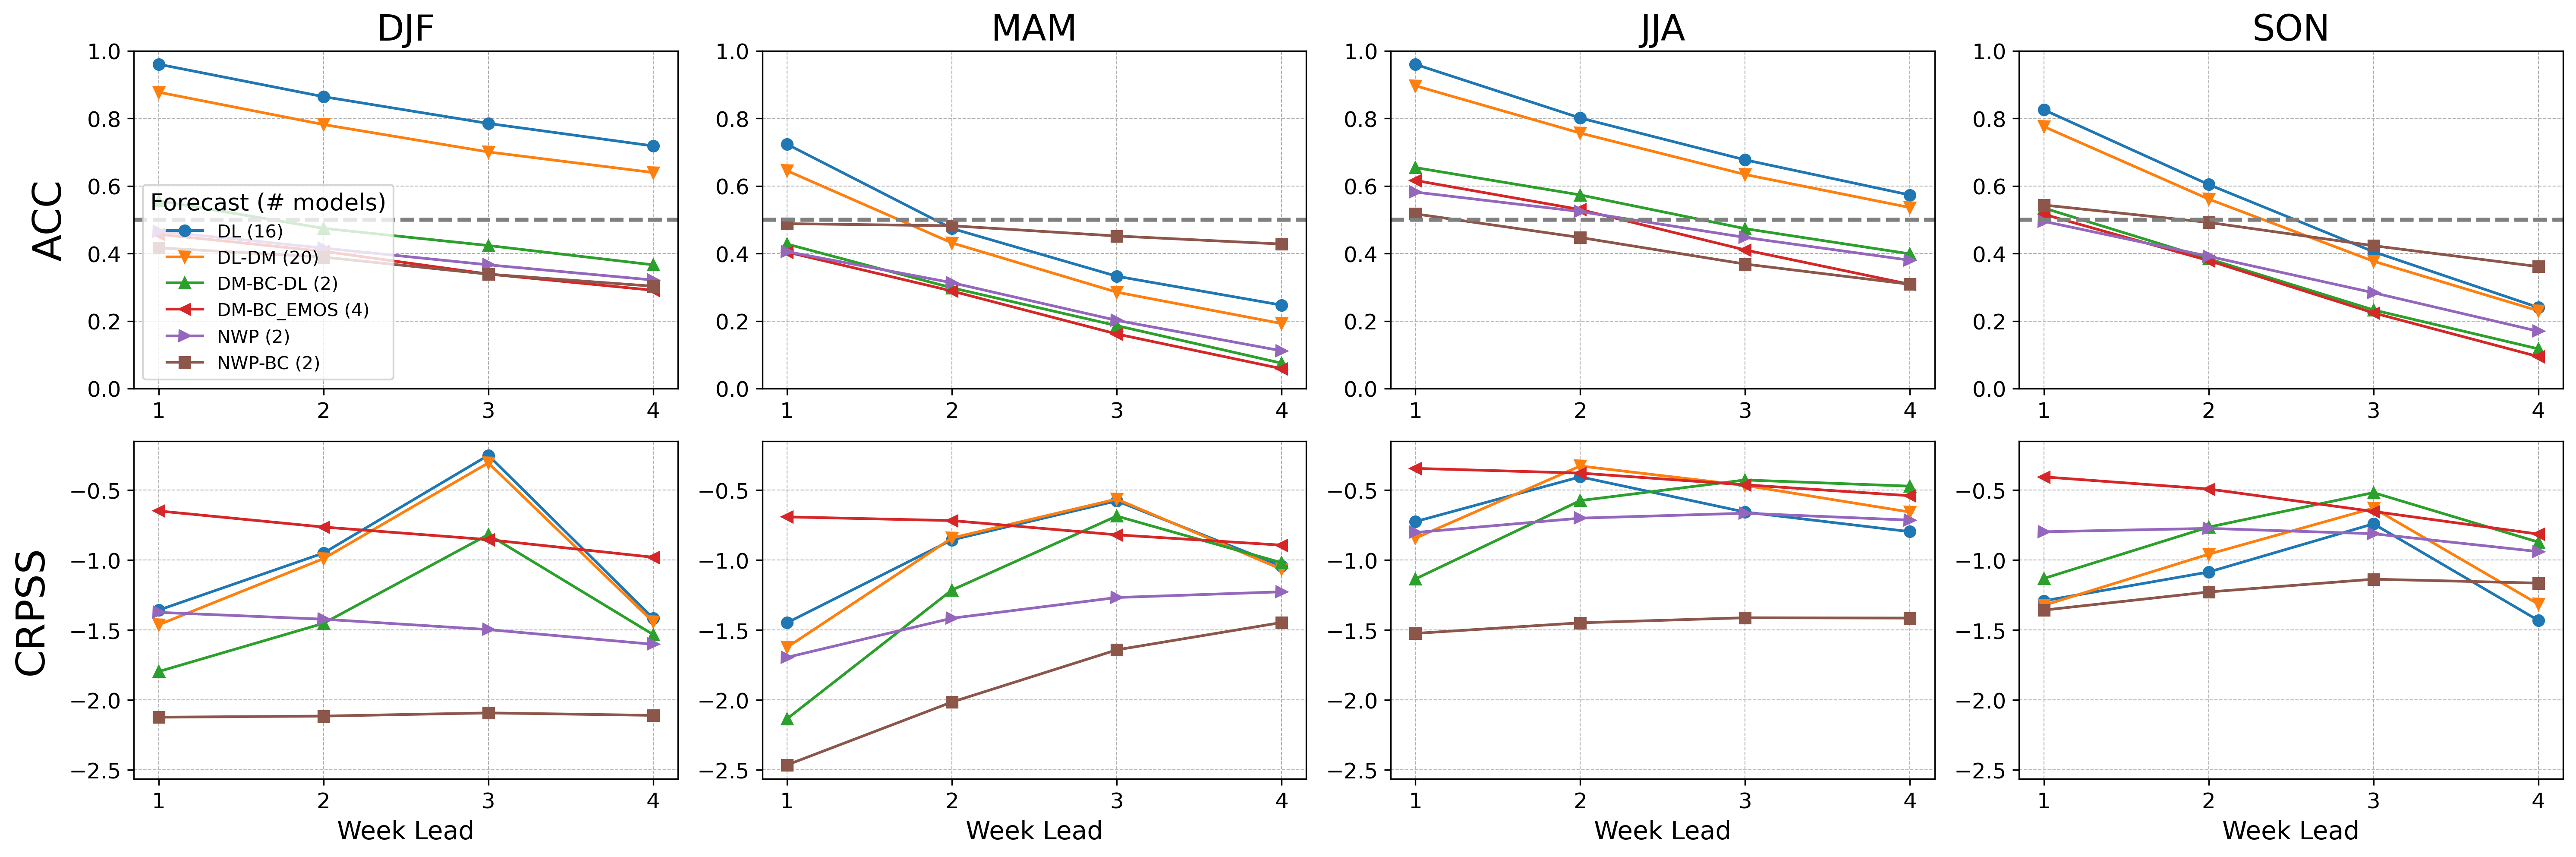

0

In [53]:
plot_ACC_CRPS_LinePlot(df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son)
